2章 自然言語処理と単語の分類表現

単語単位で考える
「単語の意味」を捉える
シソーラス
カウントベース
推論ベースの手法(Word2vec)

シソーラス
単語を意味ごとにグループ分け
意味上の上下関係を構築
このように集合としてとらえる

人為的なので多くの欠点が存在

カウントベース
コーパス(corpus)という大量のテキストデータを利用


In [1]:
text = 'You say goodbye and I say hello.'
print(text)

text = text.lower()
print(text)

text = text.replace('.', ' .')
print(text)

words = text.split(' ')
print(words)

word_to_id = {}
id_to_word = {}
for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

print(word_to_id)
print(id_to_word)

You say goodbye and I say hello.
you say goodbye and i say hello.
you say goodbye and i say hello .
['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [2]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
print(corpus)

[0 1 2 3 4 1 5 6]


コーパスの作成ができた。以上の操作を関数preprocess()として作成した。

In [3]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [4]:
#実行例
text = 'You say goodbye and I say hello.'
preprocess(text)

(array([0, 1, 2, 3, 4, 1, 5, 6]),
 {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'})

単語をRGBのように表現する。すなわちベクトルで表すことを目標にする。これを単語の分散表現という。\
分布仮説; 単語の意味は周囲の単語によって決まるという考え\
コンテキスト; 注目する単語の周囲の単語のこと。\
ウィンドウサイズ; 注目する単語から左右に何単語分コンテキストに含めるかを表す数\

In [5]:
import sys
sys.path.append('..')
import numpy as np

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


共起行列

In [6]:
C = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0]
], dtype = np.int32)

In [7]:
print(C[0]) #単語ID0のベクトル

[0 1 0 0 0 0 0]


In [8]:
print(C[6]) #単語ID6のベクトル

[0 0 0 0 0 1 0]


In [9]:
print(C[word_to_id['goodbye']]) #goodbeyのベクトル

[0 1 0 1 0 0 0]


コーパスから共起行列を作成する関数create_co_matrix()\
corpusは単語IDのリスト, vocab_sizeは語彙数, window_sizeはウィンドウサイズ

In [10]:
def create_co_matrix(corpus, vocab_size, window_size = 1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype = np.int32) #行列の初期化
    
    for idx, word_id in enumerate(corpus): #インデックス, 要素
        for i in range(1, window_size + 1):
            left_idx = idx - 1
            right_idx = idx + 1
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix

In [11]:
#実行
co_matrix = create_co_matrix(corpus, 7)
print(co_matrix)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


ベクトル間の類似度\
コサイン類似度; 2つのベクトルについて、分子に内積、分母に各ベクトルのノルム(大きさ)で定められる。これはcosに相当し、向きの類似度を表す。

In [12]:
def cos_simlarity(x, y, eps = 1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    return np.dot(nx, ny)

In [13]:
#実行
text = "You say goodbye and I say  hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
c2 = C[word_to_id['say']]

print(cos_simlarity(c0, c1))
print(cos_simlarity(c0, c2))

0.7071067691154799
0.0


In [14]:
#実行
text = "You say goodbye and I say hello. We are good friends. I talk with you freely"
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['talk']]
c1 = C[word_to_id['are']]
c2 = C[word_to_id['say']]

print(cos_simlarity(c0, c1))
print(cos_simlarity(c0, c2))
print(cos_simlarity(c1, c2))

0.0
0.3535533863255068
0.0


most_similar()関数の実装
ある単語がクエリとして与えられたとき、そのクエリに対して類似した単語をランキング形式で表示する関数

In [15]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top = 5):
    #クエリを取り出す
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    #コサイン類似度の算出
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_simlarity(word_matrix[i], query_vec)
        
    #コサイン類似度が高い順に出力
    count = 0
    for i in (-1 * similarity).argsort(): #argsort()はインデックスを小さい順に並べる -1を掛けると大きい順となる
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

In [16]:
#実行
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


簡単ではあるが、カウントベース手法を実装できた。主語である'i'が高くなっていることが確認できたが、'goodbye', 'hello'といった'you'とはあまり類似していないような単語も同様の数値を示している。これはtextが少ないからであると考えられる。

In [17]:
#実行
text = "You say goodbye and I say hello. You go to my house. I go to your house. I do not say goodbye to you."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C)


[query] you
 i: 0.8017837198720819
 hello: 0.8017837170373484
 house: 0.6172133949957571
 goodbye: 0.46291004624681786
 go: 0.30860669749787856


 PMI(相互情報量)の実装\
$$PMI(x,y) = log_2\frac{P(x,y)}{P(x)P(y)}$$
$$PMI(x,y) = log_2\frac{\frac{P(x,y)}{N}}{\frac{P(x)}{N}\frac{P(y)}{N}} = log_2\frac{C(x,y)N}{C(x)C(y)}$$
$P(x)$, $P(y)$は単語x, yの出現する確率\
$P(x,y)$は単語x, yの共起する確率\
$C(x,y)$は単語x, yの共起する回数\
$C(x)$, $C(y)$は単語x, yの出現回数\
$N$はコーパスに含まれる単語数\
$C(x, y)$が0のとき$log_20=-\infty$となるため、正の相互情報量PPMIを用いる。
$$PPMI(x, y) = max(0, PMI(x,y))$$

In [18]:
def ppmi(C, verbose = False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis = 0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]): #行
        for j in range(C.shape[1]): #列
            pmi = np.log2(C[i, j] * N / (S[i] * S[j]) + eps)
            M[i,j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total/100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [19]:
#実行
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

W = ppmi(C)

np.set_printoptions(precision = 3)
print('covariance matrix')
print(C)
print('-'*60)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
------------------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [20]:
print(W[word_to_id['you']])
print(W[word_to_id['goodbye']])

[0.    1.807 0.    0.    0.    0.    0.   ]
[0.    0.807 0.    1.807 0.    0.    0.   ]


共起行列からPPMI行列に変換できた。
重要度の低い要素は0となっている。この手法では単語数がそのまま次元数になるため、大きなコーパスを扱うのにあまり向いていないと考えられる。

次元削減\

In [21]:
import numpy as np
import matplotlib.pyplot as plt

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

#SVD
U, S, V = np.linalg.svd(W)

In [22]:
#確認
print(C[0]) #共起行列
print(C.shape)
print(W[0]) #PPMI行列
print(W.shape)
print(U[0]) #SVD
print(U.shape)
print(U[0, :2]) #次元削減

[0 1 0 0 0 0 0]
(7, 7)
[0.    1.807 0.    0.    0.    0.    0.   ]
(7, 7)
[-3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01  0.000e+00  9.323e-01
  2.226e-16]
(7, 7)
[-3.409e-01 -1.110e-16]


2次元に次元削減ができている

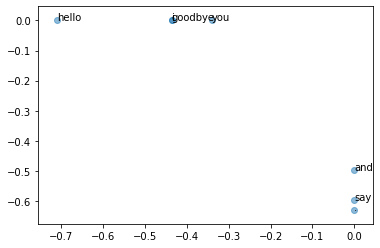

In [23]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    #annoatate(String, (x, y)) は(x, y)にStringを描画
#print(U[:, 0])
plt.scatter(U[:, 0], U[:, 1], alpha = 0.5)
plt.show()

SVDではi, goodbye, youが比較的近い位置に位置していることが分かった。

PTBデータセット

In [24]:
import sys
sys.path.append('..')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train') #preprocessと同じ扱い方,trainは訓練用, testはテスト用, validは検証用

#確認用
print('corpus_size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print('id_to_word[len(id_to_word)-1]', id_to_word[len(id_to_word)-1])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("wors_to_id['lexus']:", word_to_id['lexus'])

Done
corpus_size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz
id_to_word[len(id_to_word)-1] unilab

word_to_id['car']: 3856
word_to_id['happy']: 4428
wors_to_id['lexus']: 7426


In [25]:
import sys
sys.path.append('..')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi


window_sixe = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

print('counting co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_sixe)

print('calsulateing PPMI ...')
W = ppmi(C, verbose = True)

print('calculateing SVD ...')
try:
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
    U, S, V = np.linalg.avd(W)
    
word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

counting co-occurrence ...
calsulateing PPMI ...


C:\Users\ken19\myFIles\my-kobo\repo5\nlp2\common\util.py:139: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
C:\Users\ken19\myFIles\my-kobo\repo5\nlp2\common\util.py:139: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)


1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.0% done
89.0% done
90.0% done
91.0% done
92.0% do

クエリyouに対してi, someone, we, anybody, somebodyなどの似たような働きを示す単語が上位に来ている。また、最も近いであろうiが類似度約0,7であり、weは0.66程度である。上位3位以降が0.55程度であることを考えると、iやweが他の単語よりyouに類似していると言える。\
クエリyearに対してはmonth, last, quarter, earlier, juneなどの副詞に相当する単語が上位を占めている。中でも、年に意味的に近いmonthが類似度0.69程度であり、だいぶ類似していると言える。\
このように感覚的に近いと思える単語が上位に来ていることが確認できた。\
クエリcarの場合は同じ意味のautoが類似度約0.66で最も上位になっている。複数形carsよりも類似度が高い結果なっている。また、一見類似していないように思えるluxuryが上位に来ている。このように感覚から外れている単語が表れることもあることが分かった。\
クエリtoyotaの場合は、motor, motorsが上位に来ている。これはtoyotaとmotorの単語の結びつきが非常に強いことを示している。類似度も約0.72と非常に大きいことが分かる。また、上記3つの単語に比べ全体的に類似度が高いことも判断できる。motor(s)以外には競合の企業を表す単語が上位に来ている。

In [26]:
querys = ['encourage', 'moment', 'hope', 'mix', 'word', 'spring']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] encourage
 educate: 0.602806806564331
 advise: 0.5481181144714355
 urge: 0.5113472938537598
 regulate: 0.5081126689910889
 attract: 0.4796712398529053

[query] moment
 minute: 0.47832849621772766
 phenomenon: 0.4470707178115845
 mid-1970s: 0.43929964303970337
 reason: 0.42851513624191284
 obstacle: 0.4188341498374939

[query] hope
 want: 0.41635143756866455
 comfort: 0.412539005279541
 ca: 0.39929574728012085
 ought: 0.35499972105026245
 pressure: 0.3437035083770752

[query] mix
 posture: 0.5046809315681458
 specifications: 0.45210132002830505
 attitude: 0.42671626806259155
 roots: 0.4209299087524414
 sweep: 0.4151420593261719

[query] word
 tremor: 0.40928590297698975
 figuring: 0.4060996174812317
 passed: 0.3936804533004761
 setback: 0.38990336656570435
 aspect: 0.38482341170310974

[query] spring
 february: 0.5507664680480957
 march: 0.5269663333892822
 april: 0.5212395787239075
 month: 0.49606606364250183
 june: 0.48717236518859863


今回は理解を深めるために、類似度の高い組を見つけることを通して、類似度を高くする条件について考える。\
いくつか思いついた単語をクエリとして試した。全体的に類似度は0.5程度であり、参考文献1の実行例のように0.7程度になあるクエリではなかった。そこで一番類似度が高かったencourage, educateが動詞であることに注目して、一般的な動詞をクエリに選んで試した。

In [27]:
querys = ['drive', 'stand', 'move', 'touch', 'go', 'feel', 'say', 'come']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] drive
 disk: 0.5266988277435303
 wipe: 0.4558466076850891
 ride: 0.43623366951942444
 slow: 0.3960356116294861
 break: 0.3730338215827942

[query] stand
 lay: 0.4818665385246277
 defend: 0.4704436659812927
 throw: 0.4553096890449524
 turn: 0.4479348361492157
 rulings: 0.44661208987236023

[query] move
 changes: 0.41549545526504517
 step: 0.3945024609565735
 pill: 0.3662164807319641
 translate: 0.3565753996372223
 accord: 0.35581302642822266

[query] touch
 preclude: 0.45137763023376465
 tightly: 0.44789525866508484
 ring: 0.431865930557251
 recommend: 0.4127454161643982
 break: 0.4089815020561218

[query] go
 stay: 0.5369476675987244
 walk: 0.5275244116783142
 lay: 0.46299460530281067
 went: 0.46055522561073303
 wipe: 0.4540635943412781

[query] feel
 know: 0.650989830493927
 think: 0.610784649848938
 guess: 0.5612886548042297
 sorry: 0.5461536049842834
 sure: 0.5056599378585815

[query] say
 believe: 0.6032611131668091
 agree: 0.5431695580482483
 contend: 0.5334901809692383
 

結果は先ほどよりも類似度が大きい組を得ることができた。\
say, believeの組が0.6程度である。比較的高くなったsayやfeelは言い換えに相当する単語が存在していて、かつその単語も比較的頻繁に使われる単語であるからではないかと考えた。\
そこで「言う」として、talk, speak, tell, call, express, declare, state, assert, remarkを考えた。

In [28]:
querys = ['talk', 'speak', 'tell', 'call', 'express', 'declare', 'state', 'assert', 'remark']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] talk
 tell: 0.5961438417434692
 radio: 0.4074557423591614
 live: 0.39927658438682556
 jokes: 0.3906444311141968
 else: 0.3864635229110718

[query] speak
 shoot: 0.49664413928985596
 catch: 0.49352118372917175
 unstable: 0.48761290311813354
 modify: 0.4774388372898102
 serve: 0.46347030997276306

[query] tell
 know: 0.7003185153007507
 appreciate: 0.6545106172561646
 talk: 0.5961438417434692
 see: 0.5744364261627197
 exactly: 0.5590279698371887

[query] call
 attract: 0.4159988760948181
 find: 0.3989780843257904
 send: 0.39178466796875
 get: 0.38503310084342957
 consider: 0.37670081853866577

[query] express
 american: 0.46856221556663513
 telephone: 0.4569395184516907
 railway: 0.455424427986145
 bristol-myers: 0.44312238693237305
 electric: 0.4361533522605896

[query] declare
 liked: 0.44081801176071167
 rebuild: 0.41295748949050903
 hints: 0.411799818277359
 detected: 0.3875722587108612
 abruptly: 0.3850403130054474

[query] state
 michigan: 0.6478172540664673
 california: 0

結果から判断すると、tell, stateを除き、あまり類似度の高い組は得られていない。類似度の観点で単語の意味だけではなく他の要素も考慮しなくてはいけないことが分かった。\

In [29]:
querys = ['of', 'as', 'in', 'at', 'on', 'from', 'by', 'with', 'along', 'among']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] of
 the: 0.6730115413665771
 a: 0.594205915927887
 in: 0.5025878548622131
 <unk>: 0.4969627857208252
 for: 0.4781818985939026

[query] as
 such: 0.5246642827987671
 well: 0.4252268671989441
 voiced: 0.36668288707733154
 tourist: 0.35225406289100647
 multiples: 0.34371283650398254

[query] in
 of: 0.5025878548622131
 the: 0.5000847578048706
 and: 0.48302239179611206
 <unk>: 0.47925493121147156
 from: 0.4732705354690552

[query] at
 economist: 0.5247272253036499
 underwriter: 0.46384668350219727
 dean: 0.4603249430656433
 analyst: 0.44740813970565796
 strategist: 0.43537503480911255

[query] on
 est: 0.4013757109642029
 the: 0.3889485001564026
 of: 0.37513166666030884
 prosecutorial: 0.3638300597667694
 trafficking: 0.34396201372146606

[query] from
 in: 0.4732705354690552
 million: 0.4259234070777893
 stemmed: 0.42048734426498413
 <unk>: 0.40884679555892944
 and: 0.39975014328956604

[query] by
 murdoch: 0.3837844133377075
 rated: 0.3755989670753479
 directly: 0.342765986919403

次に、クエリとして前置詞の場合を考えた。\
結果はsuch asやof theのように比較的でセットで使われることの多い単後の組が類似度が高かった。また、前置詞同士の組の類似度が高くなる傾向があることもわかった。\
一般的に多く使われる単語ではPMIの定義から真数部分の分母$C(x)C(y)$が大きくなってしまい、類似度があまり大きくならないということが確認できた。\
したがって類似度を高くするには定義から$C(x)C(y)$が小さく、$C(x,y)$が大きくなる、すなわち結びつきの強い単語が存在することが予想できるあまり一般的でない単語をクエリに選んであげると類似度の高い組が得られると考えられる。参考文献1の実行例だとhondaなどがよい例である。

In [30]:
querys = ['1980s', 'california', 'nixon', 'hahn', 'jerry', 'fast-food', 'pasadena', 'debentures', 'aluminum']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] 1980s
 1960s: 0.47352468967437744
 1970s: 0.4041314423084259
 gyrations: 0.392749547958374
 bpca: 0.3796602487564087
 corresponding: 0.37337809801101685

[query] california
 florida: 0.611814558506012
 michigan: 0.6063764691352844
 arizona: 0.6037331223487854
 state: 0.5979580879211426
 northern: 0.5937544703483582

[query] nixon
 reagan: 0.5862619876861572
 deng: 0.5707921385765076
 sherman: 0.5473047494888306
 patel: 0.5429495573043823
 bush: 0.5321998000144958

[query] hahn
 achenbaum: 0.500206470489502
 savaiko: 0.47107070684432983
 hutchinson: 0.46491456031799316
 conway: 0.46259185671806335
 rifenburgh: 0.45032182335853577

[query] jerry
 gerald: 0.7485620975494385
 thomas: 0.7159087061882019
 dan: 0.714588463306427
 terry: 0.6966327428817749
 patrick: 0.6857182383537292

[query] fast-food
 chain: 0.6683458089828491
 restaurant: 0.6529269218444824
 chains: 0.6108901500701904
 store: 0.6037276983261108
 grocery: 0.5992923974990845

[query] pasadena
 santa: 0.5984304547309

ptb.train.txt内から上述したような特徴を持つと考えられる単語を適当に選び、実行した。\
結果は確かに類似度が高い組が得られた。特にjerryやdebenturesは上位の単語の類似度が非常に高く、上述した特徴を強く持っていると考えられる。

類似度を高くするための条件について考えることを通して、よりカウントベースの手法についての理解が深まった。

参考文献
1. ゼロから作るDeep Learning --自然言語処理偏